# Principal Component Analysis (PCA)
This notebook will be used to perform PCA to reduce the dimensionality of our data while retaining the majority of our original data's variance. While this isn't strictly necessary in our situation, since our feature matrix is not extremely large, it will help provide insight as to which principal components contribute most to the variance in our data

In [1]:
import os
import sys
from pathlib import Path

# Get current file path and change the working directory to the project root
NOTEBOOK_DIR = Path().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent
os.chdir(PROJECT_ROOT)
sys.path.append(str(PROJECT_ROOT))

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, roc_curve, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from src.config import USE_ELO, USE_H2H, USE_DIFF, DELETE_ORIGINAL_DIFF

## List of all Features in the Feature Matrix
Before PCA, let's explore every single feature present in the feature matrix.

In [17]:
from src.util.notebook_utils import get_feature_matrix

X_train, _, _, _ = get_feature_matrix()
print(X_train.columns)
print(len(X_train.columns))

Index(['form_wins_diff', 'form_points_diff', 'form_goals_scored_diff',
       'form_goals_conceded_diff', 'form_shots_on_target_diff',
       'form_fouls_committed_diff', 'form_win_streak_diff',
       'form_possession_pct_diff', 'elo_diff_pre', 'h2h_matches', 'h2h_draws',
       'h2h_wins_diff', 'h2h_goals_scored_diff', 'h2h_goals_conceded_diff',
       'h2h_win_pct_diff', 'odds_home_win', 'odds_draw', 'odds_away_win',
       'home_possession_pct', 'away_possession_pct', 'possession_diff'],
      dtype='object')
21


Now, let's continue with Principal Component Analysis.

## Principal Component Analysis

### Load Data
Load the dataset from the CSV and define the feature and target matrices.

In [2]:
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

# Load data and define target / feature matrix.
DATA_PATH = "data/processed/processed_15_25_n10.csv"
df = pd.read_csv(DATA_PATH, parse_dates=["date"])

# Target: home win (1) vs not home win (0)
df["y"] = (df["result"] == "H").astype(int)

In [3]:
# Build feature list based on configuration
def get_pca_features(df_columns):
    """
    Dynamically build feature list based on config settings.
    """
    cols_for_pca = []
    
    # Always include odds
    cols_for_pca.extend(["odds_home_win", "odds_draw", "odds_away_win"])
    
    # Add Elo features based on config
    if USE_ELO:
        if USE_DIFF and DELETE_ORIGINAL_DIFF:
            # Only diff
            cols_for_pca.append("elo_diff_pre")
        else:
            # Include available Elo features
            if not USE_DIFF:
                # No diff features, include home/away
                if "elo_home_pre" in df_columns:
                    cols_for_pca.append("elo_home_pre")
                if "elo_away_pre" in df_columns:
                    cols_for_pca.append("elo_away_pre")
            else:
                # Using diff but not deleting originals - include diff
                if "elo_diff_pre" in df_columns:
                    cols_for_pca.append("elo_diff_pre")
    
    # Add form features based on config
    if USE_DIFF and DELETE_ORIGINAL_DIFF:
        # Only diff features
        diff_cols = [c for c in df_columns if c.startswith('form_') and c.endswith('_diff')]
        cols_for_pca.extend(diff_cols)
    else:
        if not USE_DIFF:
            # No diff, include home features (you can customize this)
            home_form_cols = [c for c in df_columns if c.startswith('form_') and c.endswith('_home')]
            cols_for_pca.extend(home_form_cols)
        else:
            # Using diff but keeping originals - include diff
            diff_cols = [c for c in df_columns if c.startswith('form_') and c.endswith('_diff')]
            cols_for_pca.extend(diff_cols)
    
    # Add H2H features based on config
    if USE_H2H:
        if USE_DIFF and DELETE_ORIGINAL_DIFF:
            # Only diff and aggregate H2H features
            h2h_cols = [c for c in df_columns if c.startswith('h2h_') and 
                       (c.endswith('_diff') or c in ['h2h_matches', 'h2h_draws'])]
            cols_for_pca.extend(h2h_cols)
        else:
            if not USE_DIFF:
                # No diff - include basic H2H features
                h2h_cols = ['h2h_matches', 'h2h_draws']
                h2h_cols = [c for c in h2h_cols if c in df_columns]
                cols_for_pca.extend(h2h_cols)
            else:
                # Using diff but keeping originals - include diff
                h2h_diff_cols = [c for c in df_columns if c.startswith('h2h_') and 
                                (c.endswith('_diff') or c in ['h2h_matches', 'h2h_draws'])]
                cols_for_pca.extend(h2h_diff_cols)
    
    # Filter to only columns that exist
    cols_for_pca = [c for c in cols_for_pca if c in df_columns]
    
    return cols_for_pca

In [4]:
cols_for_pca = get_pca_features(df.columns)
print(f"Using {len(cols_for_pca)} features for PCA based on config:")
print(f"  USE_ELO: {USE_ELO}")
print(f"  USE_H2H: {USE_H2H}")
print(f"  USE_DIFF: {USE_DIFF}")
print(f"  DELETE_ORIGINAL_DIFF: {DELETE_ORIGINAL_DIFF}")
print(f"\nFeatures: {cols_for_pca}\n")

Using 18 features for PCA based on config:
  USE_ELO: True
  USE_H2H: True
  USE_DIFF: True
  DELETE_ORIGINAL_DIFF: True

Features: ['odds_home_win', 'odds_draw', 'odds_away_win', 'elo_diff_pre', 'form_wins_diff', 'form_points_diff', 'form_goals_scored_diff', 'form_goals_conceded_diff', 'form_shots_on_target_diff', 'form_fouls_committed_diff', 'form_win_streak_diff', 'form_possession_pct_diff', 'h2h_matches', 'h2h_draws', 'h2h_wins_diff', 'h2h_goals_scored_diff', 'h2h_goals_conceded_diff', 'h2h_win_pct_diff']



In [5]:
X = df[cols_for_pca]
y = df["y"].values

# Safety check: no missing values (if this fails, you need to clean or impute)
assert not X.isnull().any().any(), "NaNs detected in X; clean or add an imputer."

### Random stratified split + PCA + Logistic regression + CV metrics

In [6]:
# Random stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Pipeline: standardize -> PCA -> logistic regression
pipe = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=0.90, random_state=0)),  # keep ~90% variance
        ("log_reg", LogisticRegression(max_iter=1000, solver="lbfgs"))
    ]
)

# Cross-validated performance on full data
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_acc = cross_val_score(pipe, X, y, cv=cv, scoring="accuracy")
cv_auc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
cv_logloss = cross_val_score(pipe, X, y, cv=cv, scoring="neg_log_loss")

print(f"CV accuracy (mean ± std): {cv_acc.mean():.4f} ± {cv_acc.std():.4f}")
print(f"CV ROC AUC (mean ± std): {cv_auc.mean():.4f} ± {cv_auc.std():.4f}")
print(f"CV log loss (mean ± std): {-cv_logloss.mean():.4f} ± {cv_logloss.std():.4f}")

CV accuracy (mean ± std): 0.6605 ± 0.0123
CV ROC AUC (mean ± std): 0.7182 ± 0.0140
CV log loss (mean ± std): 0.6087 ± 0.0126


In [7]:
# Fit on train split and evaluate on held-out test
pipe.fit(X_train, y_train)

y_proba_test = pipe.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

print("\nHeld-out test metrics:")
print("Test accuracy:", accuracy_score(y_test, y_pred_test))
print("Test log loss:", log_loss(y_test, pipe.predict_proba(X_test)))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba_test))


Held-out test metrics:
Test accuracy: 0.6564580559254327
Test log loss: 0.6056463413114941
Test ROC AUC: 0.7233949367452146


### Inspect PCA Structure and Derive Feature Importance in Original Space

In [8]:
# Refit on all data to get final PCA + coefficients for interpretation
pipe.fit(X, y)

scaler = pipe.named_steps["scaler"]
pca = pipe.named_steps["pca"]
log_reg = pipe.named_steps["log_reg"]

explained = pca.explained_variance_ratio_
cum_explained = np.cumsum(explained)

print("Number of PCs used:", pca.n_components_)
print("Explained variance ratio per PC:", explained)
print("Cumulative explained variance:", cum_explained)

Number of PCs used: 9
Explained variance ratio per PC: [0.43940995 0.12156848 0.08281368 0.07340647 0.05316508 0.05278344
 0.03981373 0.03322175 0.02872597]
Cumulative explained variance: [0.43940995 0.56097843 0.64379211 0.71719858 0.77036365 0.8231471
 0.86296083 0.89618258 0.92490855]


In [9]:
# Approximate coefficient for each original (standardized) feature:
# beta_orig ≈ W^T * beta_pcs, where W = pca.components_
if log_reg.coef_.shape[0] == 1:  # binary case
    beta_pcs = log_reg.coef_[0]      # shape (n_components,)
    W = pca.components_              # shape (n_components, n_features)
    beta_orig = beta_pcs @ W         # shape (n_features,)

    feature_importance = pd.Series(beta_orig, index=cols_for_pca)
    feature_importance_abs = feature_importance.abs().sort_values(ascending=False)

    print("\nApprox. feature importance on standardized scale (top 15):")
    print(feature_importance_abs.head(15))
else:
    print("\nMulticlass logistic regression detected.")
    print("Inspect `log_reg.coef_` together with `pca.components_` for class-wise effects.")


Approx. feature importance on standardized scale (top 15):
form_possession_pct_diff     0.315678
odds_home_win                0.230312
odds_away_win                0.196671
elo_diff_pre                 0.172077
form_goals_conceded_diff     0.100099
form_win_streak_diff         0.091144
form_shots_on_target_diff    0.086873
odds_draw                    0.082605
h2h_draws                    0.043665
form_goals_scored_diff       0.032731
form_wins_diff               0.020753
h2h_win_pct_diff             0.016487
h2h_matches                  0.015929
h2h_goals_scored_diff        0.012964
h2h_goals_conceded_diff      0.012964
dtype: float64


### Scree Plot & PC1 vs PC2 Colored By Outcome

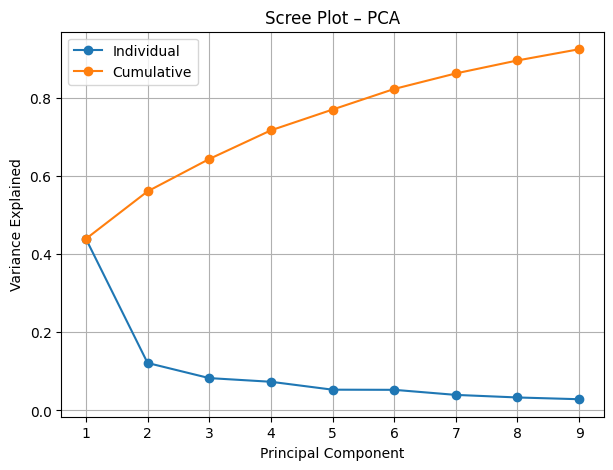

In [10]:
# Scree plot
components = np.arange(1, len(explained) + 1)

plt.figure()
plt.plot(components, explained, marker="o", label="Individual")
plt.plot(components, cum_explained, marker="o", label="Cumulative")
plt.xlabel("Principal Component")
plt.ylabel("Variance Explained")
plt.title("Scree Plot – PCA")
plt.legend()
plt.show()

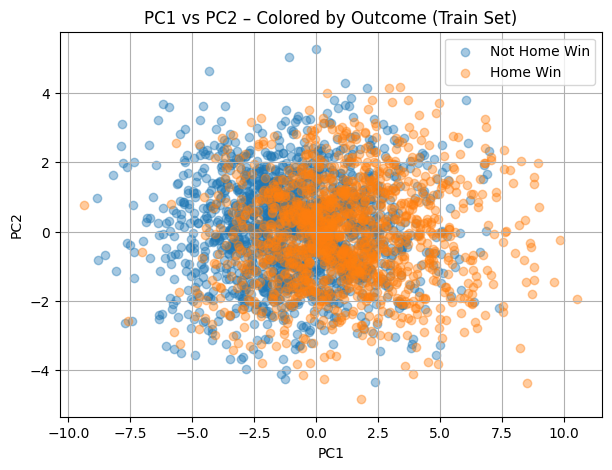

In [11]:
# PC1 vs PC2 scatter, colored by outcome (on training set)
X_train_scaled = scaler.transform(X_train)
X_train_pcs = pca.transform(X_train_scaled)

pc1 = X_train_pcs[:, 0]
pc2 = X_train_pcs[:, 1]

plt.figure()
plt.scatter(pc1[y_train == 0], pc2[y_train == 0], alpha=0.4, label="Not Home Win")
plt.scatter(pc1[y_train == 1], pc2[y_train == 1], alpha=0.4, label="Home Win")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PC1 vs PC2 – Colored by Outcome (Train Set)")
plt.legend()
plt.show()

### ROC Curve, Calibration Curve, Confusion Matrix (test set)

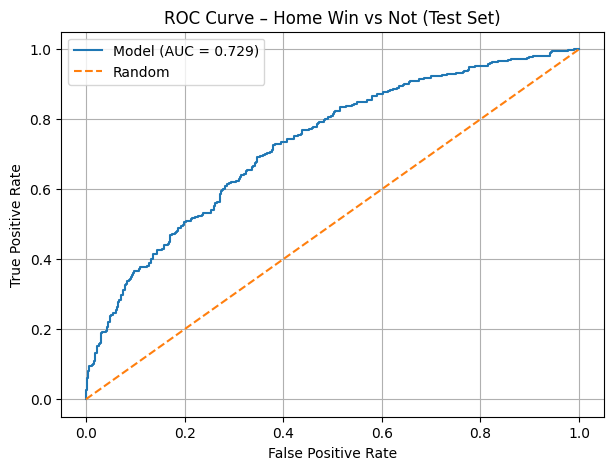

In [12]:
# Recompute probs/preds for clarity
y_proba_test = pipe.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= 0.5).astype(int)

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
auc = roc_auc_score(y_test, y_proba_test)

plt.figure()
plt.plot(fpr, tpr, label=f"Model (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Home Win vs Not (Test Set)")
plt.legend()
plt.show()

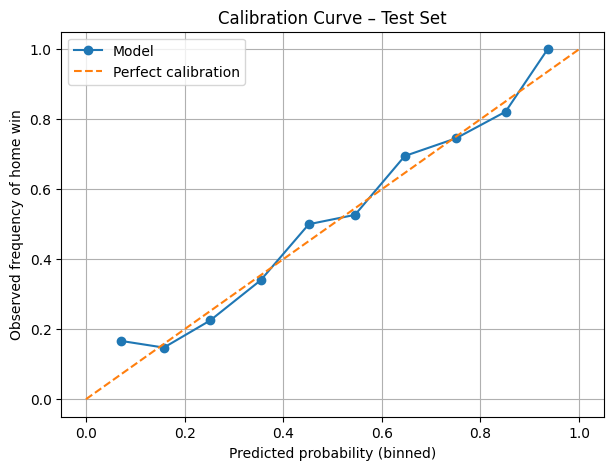

In [13]:
# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_proba_test, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker="o", label="Model")
plt.plot([0, 1], [0, 1], "--", label="Perfect calibration")
plt.xlabel("Predicted probability (binned)")
plt.ylabel("Observed frequency of home win")
plt.title("Calibration Curve – Test Set")
plt.legend()
plt.show()

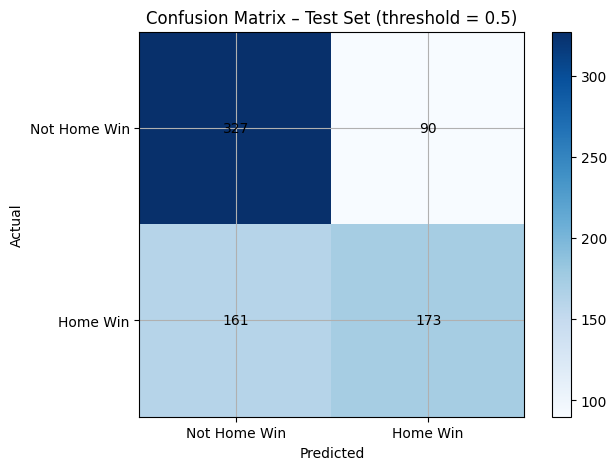

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

plt.figure()
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks([0, 1], ["Not Home Win", "Home Win"])
plt.yticks([0, 1], ["Not Home Win", "Home Win"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.title("Confusion Matrix – Test Set (threshold = 0.5)")
plt.show()

### Bar Plot for Top-N Feature Importance (absolute |beta|)

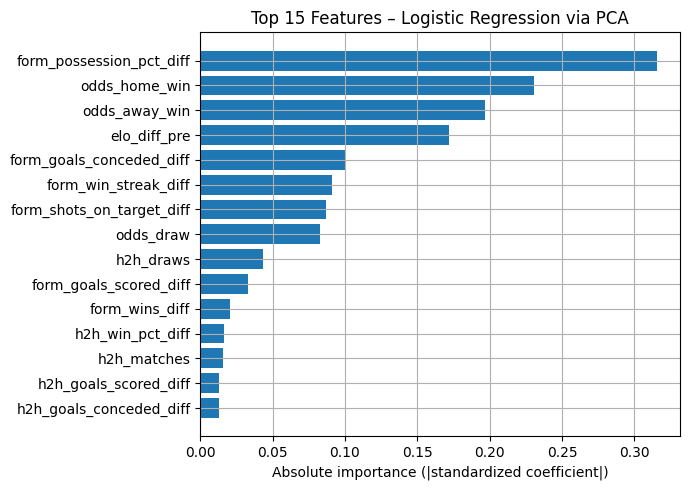

In [15]:
N = 15
fi_abs = feature_importance_abs.head(N)

plt.figure()
plt.barh(fi_abs.index[::-1], fi_abs.values[::-1])
plt.xlabel("Absolute importance (|standardized coefficient|)")
plt.title(f"Top {N} Features – Logistic Regression via PCA")
plt.tight_layout()
plt.show()